In [1]:
# Import necessary modules
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils import data
from torch.optim.lr_scheduler import StepLR
import string
import math
import time
import matplotlib.pyplot as plt
import numpy as np


In [3]:
# Clear cuda memory
torch.cuda.empty_cache()
# Use GPU if available otherwise use CPU
use_cuda = torch.cuda.is_available()
if use_cuda: print("Using GPU") 
else: print("Using CPU")
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

Using GPU


In [4]:
# Choose whether to use SGD or Adam optimizer
# global optimizer_choice
# optimizer_choice = input("Do you want to use SGD or Adam optimizer? Enter 1 for SGD or enter 2 for Adam, then press ENTER")
optimizer_choice = '2'

Do you want to use SGD or Adam optimizer? Enter 1 for SGD or enter 2 for Adam, then press ENTER2


In [5]:
# Load document into memory
def load_document(filename) -> str:
    # open the file as read only
    file = open(filename, 'r')
    # read all text in the file
    text = file.read()
    # close the file
    file.close()
    return text

In [7]:
# Load train dataset
train_filename = '/content/drive/MyDrive/LMDatasets/nchlt_text.zu.train'
train_document = load_document(train_filename)
# Load validation dataset
valid_filename = '/content/drive/MyDrive/LMDatasets/nchlt_text.zu.valid'
valid_document = load_document(valid_filename)
# Load test dataset
test_filename = '/content/drive/MyDrive/LMDatasets/nchlt_text.zu.test'
test_document = load_document(test_filename)

In [8]:
# Create tokens from the document
def clean_data(document) -> list :
    # Split by sentences
    sentences = document.split(".")
    # Split sentences into words
    words = [x.split() for x in sentences]

    # Remove punctuation from each token
    table = str.maketrans('', '', string.punctuation)

    for i,s in enumerate(words):
      words[i] = [w.translate(table) for w in s]
      # Normalise to lower case
      words[i] = [word.lower() for word in s]
      # Remove empty list index using list comprehension
      words[i] = [i for i in words[i] if i]

    return words
 

In [9]:
# Call function to clean document and view number of tokens
train_sentence = clean_data(train_document)

print('Total Tokens: %d' % len(train_sentence))
print(f"First sentence: {train_sentence[0]}")

Total Tokens: 94039
First sentence: ['funda', 'umhlahlandlela', 'wesicelo', 'sokujoyina', 'ekhasini', '7', 'ngokucophelela,', 'njengoba', 'uqukethe', 'ulwazi', 'olubalulekile', 'oluzokusiza', 'ekugcwaliseni', 'ifomu', 'lokufaka', 'isicelo', 'sokujoyina', 'ngendlela', 'efanele']


In [10]:
def unknownWords(words) :
    # From word mapping to index, create a dictionary of count of words
    words_dict = {}
    for index, word in enumerate(words) :
      for w in words[index] :
        if w in words_dict:
            words_dict[w] +=1
        else:
            words_dict[w] = 1

    # Create train set and replace all words that occur only once in the training data with UNK token
    for index, word in enumerate(words) :
      for i, w in enumerate(words[index]) :
        if words_dict[w] == 1 :
            words[index][i] = "UNK"
    
    train_set = []
    for sentence in words:
      for word in sentence:
          train_set.append(word)

    return words, train_set, words_dict

In [11]:
train_words, train_set, test_words_dict = unknownWords(train_sentence)
# Create training vocabulary
train_vocabulary = list(set(train_set))

In [12]:
print('Total TrainSet: %d' % len(train_set))
print('Total Vocabulary: %d' % len(set(train_vocabulary)))
print(f"TrainSet UNK: {train_set.count('UNK')}")

Total TrainSet: 1294312
Total Vocabulary: 81865
TrainSet UNK: 133954


In [13]:
# Create word-index mapping vocabulary for constructing context
train_word_to_index={train_word: i for i, train_word in enumerate(train_vocabulary)}

In [14]:
# Build the trigrams from the list of training set
def buid_trigrams(train_words, word_to_index) :
  trigrams=[]
  torch_trigrams_input=[]
  torch_trigrams_output=[]
  
  for index, sentence in enumerate(train_words) :
    for i in range (len(train_words[index])-2):
      context=[]
      # Create trigram
      trigrams.append(([train_words[index][i],train_words[index][i+1]],train_words[index][i+2]))
      # Build context
      context.append(word_to_index[train_words[index][i]])
      context.append(word_to_index[train_words[index][i+1]])
      target = word_to_index[train_words[index][i+2]]
      
      # Prepare input and output tensors for torch dataset
      torch_trigrams_input.append(torch.tensor(context,dtype=torch.long,device=device))
      torch_trigrams_output.append(torch.tensor([target],dtype=torch.long,device=device))

  return (torch_trigrams_input, torch_trigrams_output)

In [15]:
torch_train_trigrams_input, torch_train_trigrams_output = buid_trigrams(train_words, train_word_to_index)

In [16]:
print(torch_train_trigrams_input[0])

tensor([39089, 34048], device='cuda:0')


In [17]:
# Verify tensors are created
print(torch_train_trigrams_input[:3])
print(torch_train_trigrams_output[:3])

[tensor([39089, 34048], device='cuda:0'), tensor([34048, 76221], device='cuda:0'), tensor([76221,  8030], device='cuda:0')]
[tensor([76221], device='cuda:0'), tensor([8030], device='cuda:0'), tensor([72977], device='cuda:0')]


In [18]:
CONTEXT_SIZE = 2 
EMBEDDING_DIM = 192 
HIDDEN_DIM = 360 
LEARNING_RATE = 0.01 #0.1 SGD learning rate
if optimizer_choice == '2': # Adam learning rate
  LEARNING_RATE = 0.001
EPOCHS = 20
BATCH_SIZE = 256
DROPOUT_RATE = 0.3
LOG_INTERVAL = 200

In [19]:
# Define Feedforward Neural Network Language Model consisting of
# 1.Input,
# 2.Projection layer,
# 3.Hidden layer
# 4.Output layer.
class FFNNLM(nn.Module):
  def __init__(self, vocabulary_size, embedding_dim, context_size):
    super(FFNNLM,self).__init__()
    self.embeddings = nn.Embedding(vocabulary_size, embedding_dim)
    self.linear1 = nn.Linear(context_size * embedding_dim * BATCH_SIZE, HIDDEN_DIM)
    self.linear2 = nn.Linear(HIDDEN_DIM, vocabulary_size)
    self.dropout = nn.Dropout(DROPOUT_RATE)

  def forward(self, inputs):
    # Using Dropout for Projection and Hidden layer
    # Prepare embeddings of projection layer for next layer's input
    embeddings = self.dropout(self.embeddings(inputs).view((1,-1)))
    # Use RelU activation function for output of hidden layer to be used on next layer
    out = self.dropout(F.relu(self.linear1(embeddings)))
    # Output layer
    out = self.linear2(out)
    # Compute log probabilities from the output layer
    log_probs = F.log_softmax(out, dim=1) 
    
    return log_probs

In [20]:
# Defines the language model from FFNNLM
def createLanguageModel():
  global losses 
  losses = []
  global lossFunction 
  #Negative Log likelihood loss
  lossFunction = nn.NLLLoss() 
  global language_model 
  # Initialize the language model
  language_model = FFNNLM(len(train_vocabulary), EMBEDDING_DIM, CONTEXT_SIZE) 
  global optimizer
  # Add Stochastic gradient descent optimizer
  if (optimizer_choice == '2'): 
    optimizer = optim.AdamW(language_model.parameters())
  else : # Default is SGD if user did not make choice
    optimizer = optim.SGD(language_model.parameters(),lr=LEARNING_RATE, momentum=0.9, nesterov=True)
    # Use learning rate scheduler
    global scheduler
    # step_size-Period of learning rate decay 
    # gamma-Multiplicative factor of learning rate decay
    scheduler = StepLR(optimizer, step_size=1, gamma=0.2)

  language_model = language_model.to(device)

In [21]:
# Call the function to create the language model
createLanguageModel()
# Print the structure of the language model
print(language_model)

FFNNLM(
  (embeddings): Embedding(81865, 192)
  (linear1): Linear(in_features=98304, out_features=360, bias=True)
  (linear2): Linear(in_features=360, out_features=81865, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [22]:
# Create a custom Dataset to be managed in DataLoader
class Dataset(data.Dataset):
    #constructor
    def __init__(self, list_IDs, labels ):
        self.labels = labels
        self.list_IDs = list_IDs

    def __len__(self):
        return len(self.list_IDs)

    def __getitem__(self, index):
        context = self.list_IDs[index]
        target = self.labels[index]

        return context,target

In [23]:
# Initialize custom Dataset class to load train tensor data into batches
training_set = Dataset(torch_train_trigrams_input, torch_train_trigrams_output)
training_loader = torch.utils.data.DataLoader(training_set,batch_size = BATCH_SIZE)

In [24]:
# Check lenght of train set and first batch
print(f"Length of training set: {len(training_set)}")
print(f"Length of first batch: {len(training_loader)}")
# Test the first trigram in the train set
print(f"First trigram: {next(iter(training_set))}")

Length of training set: 1110370
Length of first batch: 4338
First trigram: (tensor([39089, 34048], device='cuda:0'), tensor([76221], device='cuda:0'))


In [25]:
# Prepare validation dataset the same as train above
valid_sentence = clean_data(valid_document)
# Handle unknown words
valid_words, valid_set, valid_words_dict = unknownWords(valid_sentence)
# Create training vocabulary
valid_vocabulary = list(set(valid_set))

In [26]:
print('Total ValidSet: %d' % len(valid_set))
print('Total Vocabulary: %d' % len(set(valid_vocabulary)))
print(f"ValidSet UNK: {valid_set.count('UNK')}")

Total ValidSet: 107328
Total Vocabulary: 9735
ValidSet UNK: 14212


In [27]:
# Create word-index mapping vocabulary for constructing context
valid_word_to_index={valid_word: i for i, valid_word in enumerate(valid_vocabulary)}

In [28]:
# Build the trigrams
torch_valid_trigrams_input, torch_valid_trigrams_output = buid_trigrams(valid_words, valid_word_to_index)

In [29]:
# Verify trigram tensors are created
print(torch_valid_trigrams_input[:3])
print(torch_valid_trigrams_output[:3])

[tensor([2549, 5068], device='cuda:0'), tensor([5068, 9218], device='cuda:0'), tensor([9218, 9218], device='cuda:0')]
[tensor([9218], device='cuda:0'), tensor([9218], device='cuda:0'), tensor([8362], device='cuda:0')]


In [30]:
# Initialize custom Dataset class to load validation tensor data into batches
validation_set = Dataset(torch_valid_trigrams_input, torch_valid_trigrams_output)
validation_loader = torch.utils.data.DataLoader(validation_set,batch_size = BATCH_SIZE)

In [31]:
# Check lenght of validation set and first batch
print(f"Length of validation set: {len(validation_set)}")
print(f"Length of first batch: {len(validation_loader)}")
# Test the first trigram in the train set
print(f"Validation First trigram: {next(iter(validation_set))}")

Length of validation set: 97274
Length of first batch: 380
Validation First trigram: (tensor([2549, 5068], device='cuda:0'), tensor([9218], device='cuda:0'))


In [32]:
# Prepare Test dataset the same as travalidationin above
test_sentence = clean_data(test_document)
# Handle unknown words
test_words, test_set, test_words_dict = unknownWords(test_sentence)
# Create training vocabulary
test_vocabulary = list(set(test_set))

In [33]:
print('Total TestSet: %d' % len(test_set))
print('Total Vocabulary: %d' % len(set(test_vocabulary)))
print(f"TestSet UNK: {test_set.count('UNK')}")

Total TestSet: 81904
Total Vocabulary: 8947
TestSet UNK: 16431


In [34]:
# Create word-index mapping vocabulary for constructing context
test_word_to_index={test_word: i for i, test_word in enumerate(test_vocabulary)}

In [35]:
# Build the trigrams
torch_test_trigrams_input, torch_test_trigrams_output = buid_trigrams(test_words, test_word_to_index)

In [36]:
# Verify trigram tensors are created
print(torch_test_trigrams_input[:3])
print(torch_test_trigrams_output[:3])

[tensor([4692, 4643], device='cuda:0'), tensor([4643, 3729], device='cuda:0'), tensor([3729, 1178], device='cuda:0')]
[tensor([3729], device='cuda:0'), tensor([1178], device='cuda:0'), tensor([8495], device='cuda:0')]


In [37]:
# Initialize custom Dataset class to load test tensor data into batches
testing_set = Dataset(torch_test_trigrams_input, torch_test_trigrams_output)
testing_loader = torch.utils.data.DataLoader(testing_set,batch_size = BATCH_SIZE)

In [38]:
# Check lenght of validation set and first batch
print(f"Length of Testing set: {len(testing_set)}")
print(f"Length of first batch: {len(testing_loader)}")
# Test the first trigram in the train set
print(f"Testing First trigram: {next(iter(testing_set))}")

Length of Testing set: 71832
Length of first batch: 281
Testing First trigram: (tensor([4692, 4643], device='cuda:0'), tensor([3729], device='cuda:0'))


In [39]:
# Create a log file for model training
global file
file = open("log_file.txt", "w")

# Variables for ploting the graph
global x_epoch
global epoch_train_loss
global validation_loss
x_epoch = []
epoch_train_loss = []
validation_loss = []

In [40]:
# Train the model and run validation after each epoch
def training(epoch):
    # Update learning rate
    global LEARNING_RATE
    if optimizer_choice == '1':
      LEARNING_RATE = scheduler.get_last_lr()
      LEARNING_RATE = LEARNING_RATE[0]
    else:
      LEARNING_RATE = optimizer.param_groups[0]["lr"]

    # Set the model in training mode using test set
    language_model.train()
    print("Start Training")
    file.write("\n")
    file.write("Start Training")
    file.write("\n")

    global epoch_train_loss
    accum_train_loss = 0

    total_loss = 0
    one_batch_count = 0
    batch_loss = 0
    batch_time = 0
    for local_batch,local_target in training_loader:
      if(len(local_batch)==BATCH_SIZE):
        before_time = time.time()
        local_loss = 0

        loc_batch, loc_target = local_batch.to(device), local_target.to(device)

        # Sets gradients of model parameters to zero, needs to be done for each epoch
        language_model.zero_grad()
        # Run forward pass and generates the log probabilities
        log_probs = language_model(loc_batch)
        
        local_target = local_target.view(BATCH_SIZE, -1)
        loss = lossFunction(log_probs, loc_target[len(loc_target)-1])
        
        #Backpropogation algorithm to update the gradients
        loss.backward() 
        # Update weights
        optimizer.step()

        local_loss += loss.item()
        
        after_time = time.time()
        batch_time += (after_time - before_time)

        local_loss_out = local_loss
        batch_loss += local_loss_out
        total_loss += local_loss_out

        accum_train_loss += local_loss * len(local_batch)

        one_batch_count += 1

        if (one_batch_count % LOG_INTERVAL == 0):
          curr_loss = batch_loss / LOG_INTERVAL
          print('| epoch {:3d} | {:4d}/{:4d} batches | lr {:02.6f} | ms/batch {:5.2f} | ''loss {:5.4f} | ppl {:8.2f}'.
                format(
                  epoch, one_batch_count, len(training_loader) // 1, LEARNING_RATE,
                  batch_time/LOG_INTERVAL*1000, curr_loss, math.exp(curr_loss))
                )
          file.write('| epoch {:3d} | {:4d}/{:4d} batches | lr {:02.5f} | ms/batch {:5.2f} | ''loss {:5.4f} | ppl {:8.2f}'.
                format(
                  epoch, one_batch_count, len(training_loader) // 1, LEARNING_RATE,
                  batch_time/LOG_INTERVAL*1000, curr_loss, math.exp(curr_loss))
                )
          file.write("\n")
          batch_loss = 0
          batch_time = 0

    # Decay Learning Rate
    if optimizer_choice == '1':
      scheduler.step()

    epoch_train_loss.append(accum_train_loss)

In [41]:
# Define the validation method used during training to validate the learning process
# calculate loss and updates gradients
def validation(epoch,train_time):
  # Set the model in evaluation mode using validation set
  language_model.eval()

  global validation_loss
  accum_validation_loss = 0
  
  total_loss = 0
  one_batch_count = 0
  batch_loss = 0
  # Turn-off gradients calculations
  with torch.set_grad_enabled(False):
    for local_batch,local_target in validation_loader:
      if(len(local_batch)==BATCH_SIZE):
        local_loss=0
        loc_batch, loc_target = local_batch.to(device), local_target.to(device)

        # Run forward pass and generates the log probabilities
        log_probs = language_model(loc_batch)

        local_target = local_target.view(BATCH_SIZE, -1)
        # Calculate loss based on what was predicted and what the next word is
        loss = lossFunction(log_probs, loc_target[len(loc_target)-1])

        local_loss += loss.item()
        
        local_loss_out = local_loss
        batch_loss += local_loss_out
        total_loss += local_loss_out

        accum_validation_loss += local_loss * len(local_batch)

        one_batch_count += 1

        curr_loss = batch_loss/one_batch_count

  file.write("-----------------------------------------------------------------------------------------")
  file.write("\n")
  print('-----------------------------------------------------------------------------------------')
  print('|end of epoch {:3d} | time {:5.2f}s| ''valid loss {:5.4f} | valid ppl {:8.2f}'.format(
      epoch,train_time, curr_loss, math.exp(curr_loss))
      )
  file.write('|end of epoch {:3d} | time {:5.2f}s| ''valid loss {:5.4f} | valid ppl {:8.2f}'.format(
      epoch,train_time, curr_loss, math.exp(curr_loss))
      )
  file.write("\n")
  print('-----------------------------------------------------------------------------------------')
  file.write("-----------------------------------------------------------------------------------------")
  batch_loss = 0
  validation_loss.append(accum_validation_loss)

In [42]:
def testing(epoch = 0):
  # Set the model in evaluation mode using testing set
  language_model.eval()

  total_loss = 0
  one_batch_count = 0
  batch_loss = 0
  with torch.set_grad_enabled(False):
      for local_batch,local_target in testing_loader:
          if(len(local_batch)==BATCH_SIZE):
              local_loss=0
              loc_batch, loc_target = local_batch.to(device), local_target.to(device)

              # Run forward pass and generates the log probabilities
              log_probs = language_model(loc_batch)

              local_target = local_target.view(BATCH_SIZE, -1)
              # Calculate loss based on what was predicted and what the next word is
              loss = lossFunction(log_probs, loc_target[len(loc_target)-1])

              local_loss += loss.item()


              local_loss_out = local_loss
              batch_loss += local_loss_out
              total_loss += local_loss_out
              one_batch_count += 1

              curr_loss = batch_loss/one_batch_count

  file.write('========================================================================================')
  file.write("\n")
  print('========================================================================================')
  print('|End of training | test loss {:5.4f} | test ppl {:8.2f}'.format(
      curr_loss, math.exp(curr_loss))
      )
  file.write('|End of training | test loss {:5.4f} | test ppl {:8.2f}'.format(
    curr_loss, math.exp(curr_loss))
    )
  file.write("\n")
  print('========================================================================================')
  file.write('========================================================================================')
  file.write("\n")

  batch_loss = 0

In [43]:
def draw_curve(epoch, train_loss, val_loss):
  print(f"x: {epoch}")
  print(f"train: {train_loss}")
  print(f"val: {val_loss}")

  x1_epoch = epoch 
  plt.plot(np.array(x1_epoch), np.array(train_loss), label='train')
  x2_epoch = epoch
  plt.plot(np.array(x2_epoch), np.array(val_loss), label='validation')
  
  plt.xlabel("Epoch")
  plt.ylabel("Average Loss")
  # Set a title of the current axes.
  plt.title('Average Train and Validation Loss per Epoch')
  # show a legend on the plot
  plt.legend()
  plt.show()

In [49]:
def draw_train_curve(epoch, val_loss):
    plt.plot(np.array(epoch), np.array(val_loss), label='train')

    plt.xlabel("Epoch")
    plt.ylabel("Average Loss")
    # Set a title of the current axes.
    plt.title('Average Train Loss per Epoch')
    # show a legend on the plot
    plt.legend()
    plt.show()

In [50]:
def draw_val_curve(epoch, train_loss):
    plt.plot(np.array(epoch), np.array(train_loss), label='validation')

    plt.xlabel("Epoch")
    plt.ylabel("Average Loss")
    # Set a title of the current axes.
    plt.title('Average Validation Loss per Epoch')
    # show a legend on the plot
    plt.legend()
    plt.show()

In [44]:
# Now, call the above functions in order to train model per epoch and validate model, printing the performance
for epoch in range(EPOCHS):
  x_epoch.append(epoch + 1)
  # Run training
  start_total_train_time=time.time()
  training(epoch)
  total_train_time = time.time() - start_total_train_time
  # Run validation
  validation(epoch, total_train_time)

Start Training
| epoch   0 |  200/4338 batches | lr 0.001000 | ms/batch 52.23 | loss 13.2437 | ppl 564528.10
| epoch   0 |  400/4338 batches | lr 0.001000 | ms/batch 38.61 | loss 12.8769 | ppl 391172.01
| epoch   0 |  600/4338 batches | lr 0.001000 | ms/batch 38.64 | loss 11.1749 | ppl 71315.07
| epoch   0 |  800/4338 batches | lr 0.001000 | ms/batch 38.53 | loss 11.3060 | ppl 81311.98
| epoch   0 | 1000/4338 batches | lr 0.001000 | ms/batch 38.50 | loss 15.3129 | ppl 4469786.34
| epoch   0 | 1200/4338 batches | lr 0.001000 | ms/batch 38.46 | loss 11.8691 | ppl 142780.36
| epoch   0 | 1400/4338 batches | lr 0.001000 | ms/batch 38.44 | loss 12.2865 | ppl 216745.04
| epoch   0 | 1600/4338 batches | lr 0.001000 | ms/batch 38.40 | loss 12.5791 | ppl 290421.93
| epoch   0 | 1800/4338 batches | lr 0.001000 | ms/batch 38.36 | loss 11.2289 | ppl 75274.38
| epoch   0 | 2000/4338 batches | lr 0.001000 | ms/batch 38.35 | loss 11.0309 | ppl 61754.75
| epoch   0 | 2200/4338 batches | lr 0.001000 | 

x: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
train: [12883404.293452263, 10434965.111952223, 10439874.041120935, 9970918.242243497, 9657184.111127809, 9269274.619587142, 9275225.249968411, 9075566.159544023, 8599648.94018073, 8801859.180149471, 8475482.144144915, 8466556.039827198, 8271978.465109607, 7970243.3123464, 7811014.84212437, 7691833.9727465045, 7833375.582008186, 7894254.606715281, 7761378.3691465175, 7737006.97784676]
val: [7719964.001464844, 8087096.577392578, 7644297.2470703125, 7094464.499755859, 6531560.83203125, 5866987.213378906, 5049590.9912109375, 3915008.4221191406, 3365980.1833496094, 2876079.8354492188, 2337603.791015625, 2185092.8088378906, 1967255.9743652344, 1841168.9956054688, 1756004.9289550781, 1669487.8229980469, 1558820.3103027344, 1527040.4780273438, 1528969.9792480469, 1456434.2373046875]


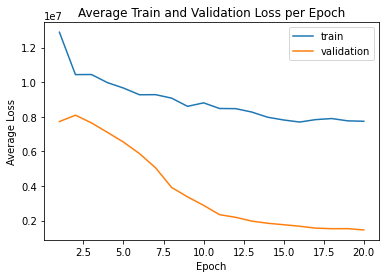

In [45]:
# Draw curve
draw_curve(x_epoch, epoch_train_loss, validation_loss)

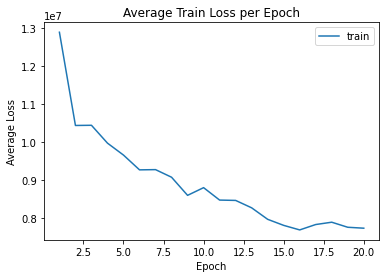

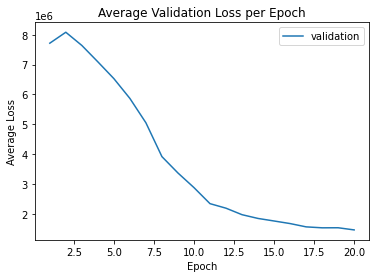

In [51]:
draw_train_curve(x_epoch, epoch_train_loss)
draw_val_curve(x_epoch, validation_loss)

In [46]:
# Now, test the model using the testing set
testing()

|End of training | test loss 17.2587 | test ppl 31285716.89


In [47]:
# Close the file after writing to log
file.close()